# Shor's algorithm in Qiskit

Disclaimer: some bugs may occur in this notebook and algorithm's implementations. If so, please report them on GitHub. Thanks :)

## Preparations

In [1]:
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram

In [2]:
import sys
import logging

logging.basicConfig(level=logging.INFO)

for handler in logging.getLogger().handlers:
    handler.setLevel(logging.WARNING)

logger = logging.getLogger('implementations.shor')
logger.setLevel(logging.INFO)

if len(logger.handlers) == 0:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    handler.setFormatter(logging.Formatter('%(name)s: %(message)s'))
    handler.addFilter(logging.Filter('implementations.shor'))
    logger.addHandler(handler)

Select numbers to test.

In [3]:
# N = 15, 21; also 35, 55 (for these, simulation will be long locally, up to 6 minutes)
N = 15

# 1 < a < N and gcd(a, N) = 1
a = 7

## Classical calculations

Compute classically reminders of `a^x mod N` for `x = 1, ..., 20`. Present results on graph, observe the period. For modular power, see https://docs.python.org/3.8/library/functions.html#pow

In [7]:
exponents = list(range(20))
values = []

for i in exponents:
    value = pow(a, i, mod=N)
    values.append(value)

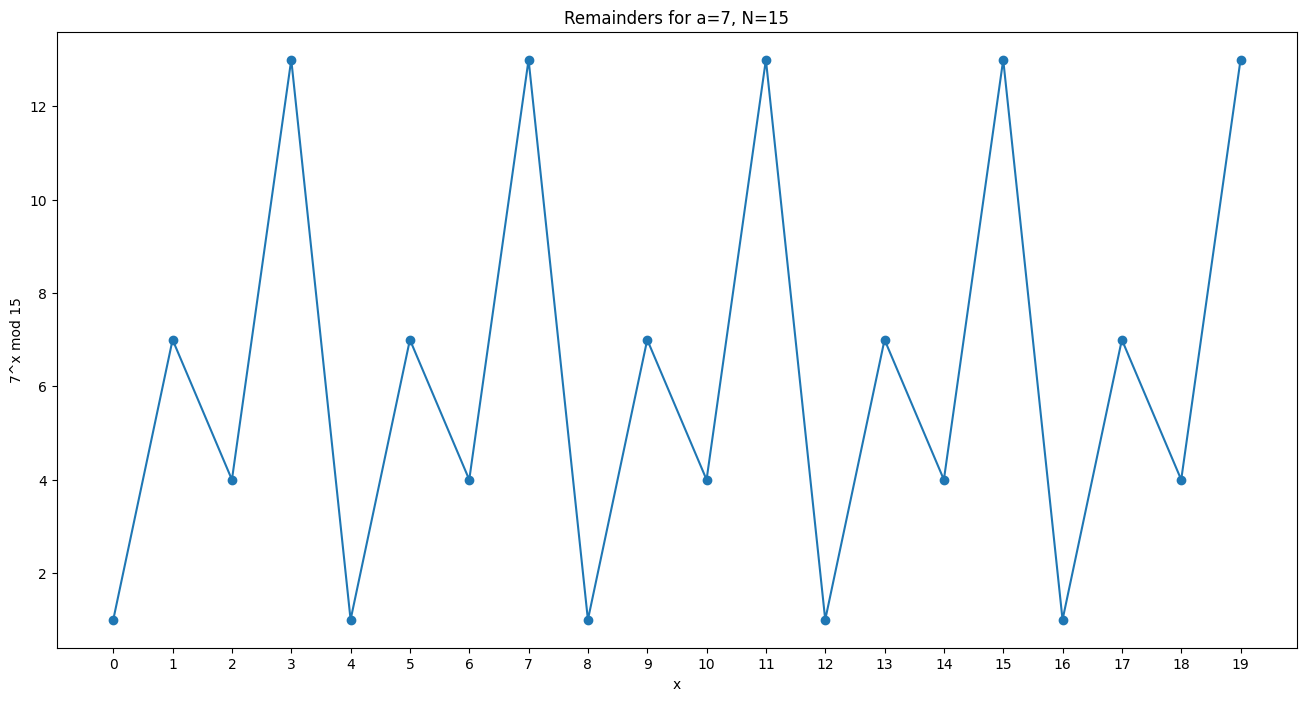

In [8]:
plt.figure(figsize=(16, 8))
plt.title(f'Remainders for a={a}, N={N}')
plt.xlabel('x')
plt.xticks(exponents)
plt.ylabel(f'{a}^x mod {N}')
plt.scatter(exponents, values)
plt.plot(exponents, values)
plt.show()

## Operation `a^x mod N` in Qiskit

Import gate for modular exponentiation. You can also use other implementations (mind the number of ancillary qubits).

In [9]:
from gates.mix.modular_exponentiation import modular_exponentiation_gate  # (n + 1 ancilla)

# from gates.takahashi.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla)

# from gates.beauregard.modular_exponentiation import modular_exponentiation_gate # (n + 2 ancilla)

# from gates.haner.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla, big size of circuit!)

Count width `n` of `N`.

In [10]:
n = N.bit_length()
print(n)

4


Create registers and circuit.

In [11]:
# input register
x_qreg = QuantumRegister(2 * n, name='x')

# output register, must contain 1
y_qreg = QuantumRegister(n, name='y')

In [12]:
# ancillary register; change the size according to selected implementation
ancillary_register_size = n + 1
aux_qreg = QuantumRegister(ancillary_register_size, name='aux')

In [13]:
circuit = QuantumCircuit(x_qreg, y_qreg, aux_qreg)

In [14]:
# prepare input register
circuit.h(x_qreg)

# prepare output register
circuit.x(y_qreg[0])

In [15]:
# append gate
gate = modular_exponentiation_gate(a, N, n)
circuit.append(gate, circuit.qubits)

In [16]:
# measure output register
y_creg = ClassicalRegister(n, name='yValue')
circuit.add_register(y_creg)
circuit.measure(y_qreg, y_creg)

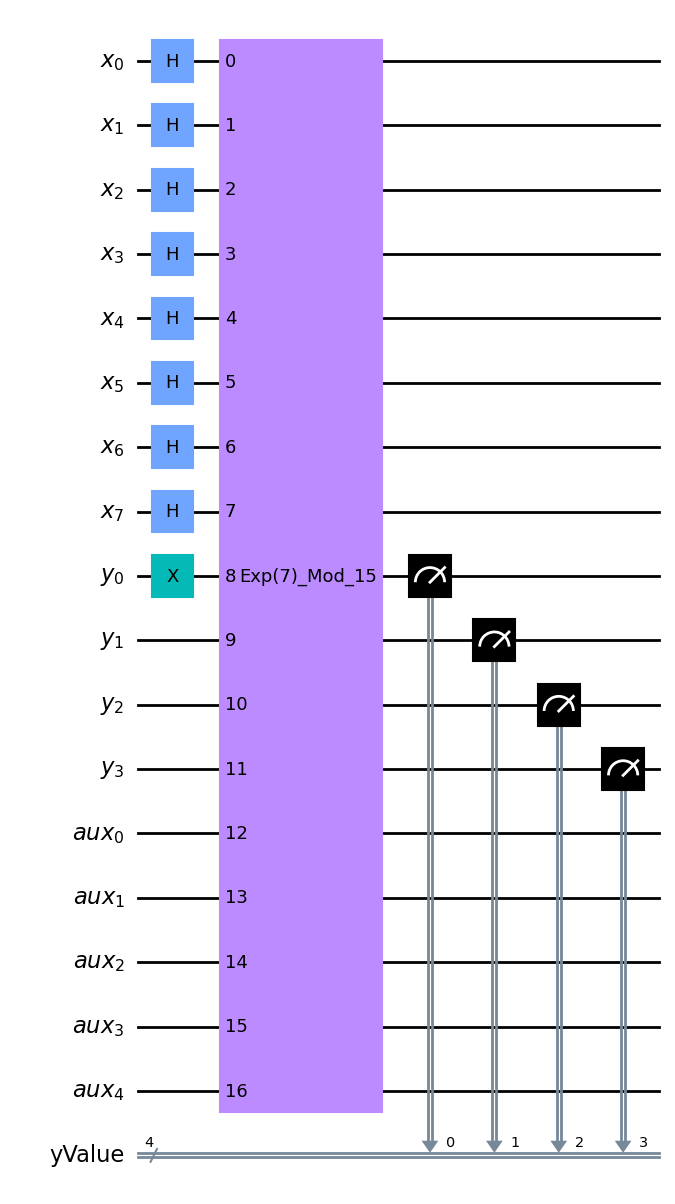

In [17]:
circuit.draw(output='mpl', fold=-1)

Run circuit. 
WARNING: ibmq_qasm_simulator is the simulator run on the IBM cloud infrastructure (not local!). 
See https://quantum-computing.ibm.com/services/resources?tab=simulators
Suggested when stronger machine is required (but mind the queue system!) 

In [18]:
def get_quantum_instance(cloud):
    if cloud:
        from qiskit import IBMQ
        provider = IBMQ.load_account()
        provider = IBMQ.get_provider(hub='ibm-q')
        backend = provider.get_backend('ibmq_qasm_simulator')
    else:
        from qiskit.providers.aer import QasmSimulator
        backend = QasmSimulator()

    return QuantumInstance(backend)

In [19]:
instance = get_quantum_instance(cloud=False)
instance.set_config(shots=64)
exponentiation_result = instance.execute(circuit)

C:\Users\micha\AppData\Local\Temp\ipykernel_12292\836715644.py:11: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  return QuantumInstance(backend)


Draw histogram. Compare results with classical calculations.

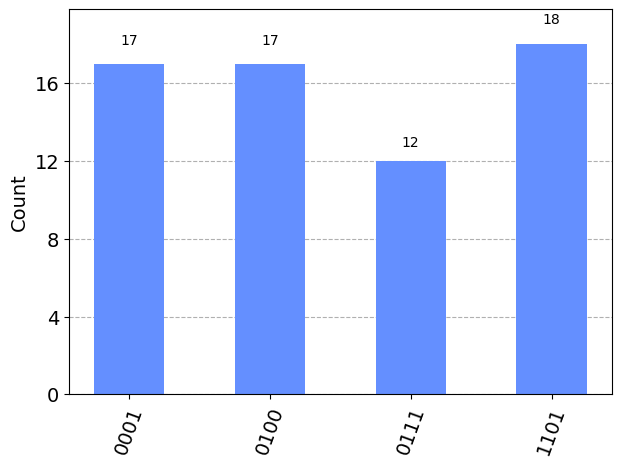

In [20]:
counts = exponentiation_result.get_counts(circuit)
plot_histogram(counts)

Let's try observe period.

In [21]:
# clone circuit
circuit2 = circuit.copy()

# measure input register
x_creg = ClassicalRegister(2 * n, name='xValue')
circuit2.add_register(x_creg)
circuit2.measure(x_qreg, x_creg)

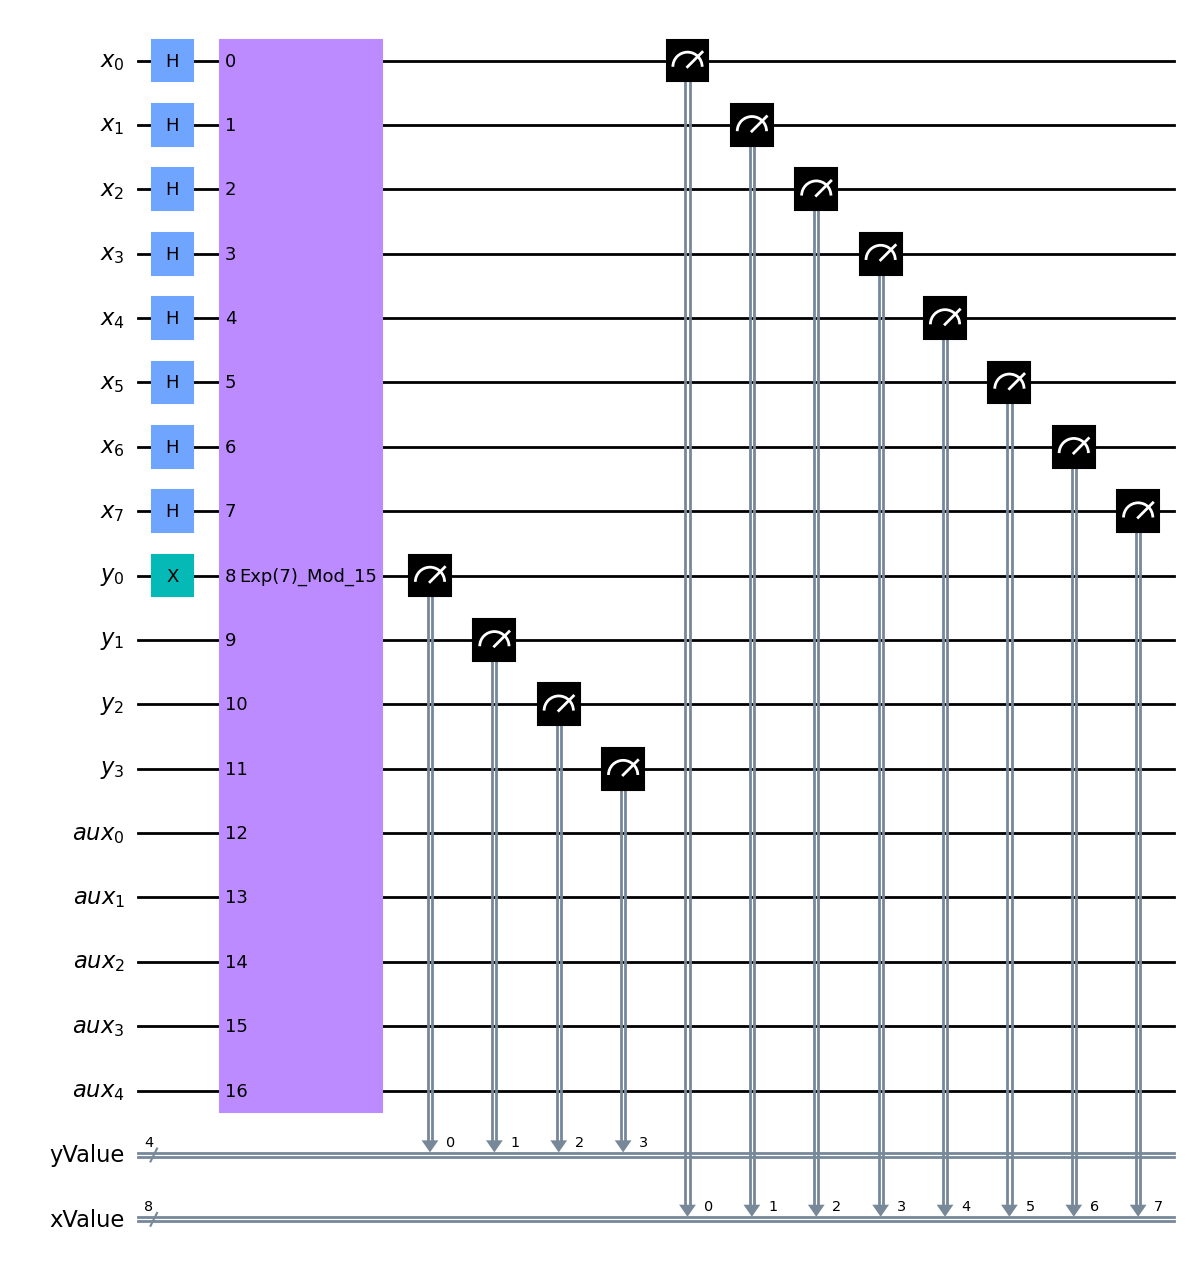

In [22]:
circuit2.draw(output='mpl', fold=-1)

In [23]:
instance.set_config(shots=128)
exponentiation_and_exponent_result = instance.execute(circuit2)

In [24]:
counts = exponentiation_and_exponent_result.get_counts(circuit2)
values_map = {}
for measurement in counts.keys():
    x, y = [int(value, base=2) for value in measurement.split(' ')]
    values = values_map.get(y, [])
    values.append(x)
    values_map[y] = values

Print measured `x` values for each exponentiation result.
You should observe that values differs from each other by constant - period `r`. (precisely, only part of them
in different runs will - think why!)

In [25]:
for y, x_values in values_map.items():
    print(y)
    print(sorted(x_values))
    print()

7
[5, 33, 37, 41, 49, 53, 57, 61, 73, 77, 93, 117, 121, 129, 157, 185, 193, 201, 209, 221, 225, 241]

4
[14, 22, 26, 54, 66, 70, 74, 98, 106, 114, 126, 134, 154, 162, 174, 178, 182, 186, 190, 194, 198, 206, 214, 226, 234, 238, 242]

13
[15, 23, 27, 31, 35, 51, 59, 67, 79, 83, 87, 91, 103, 111, 115, 131, 147, 151, 171, 183, 187, 191, 207, 215, 219, 227, 239, 255]

1
[16, 32, 36, 44, 48, 60, 72, 96, 100, 116, 124, 132, 136, 140, 144, 152, 168, 176, 180, 188, 192, 196, 200, 204, 212, 228, 240, 248]



## Finding period / order in Qiskit

Import Shor's algorithm implementation.
Similarly to modular exponentiation gate, you can test different implementations.

In [26]:
from implementations.mix import MixShor as Shor

# from implementations.takahashi import TakahashiShor as Shor

# from implementations.beauregard import BeauregardShor as Shor

# from implementations.haner import HanerShor as Shor # (big size of circuit!)

For usage, class instance have to be created.
WARNING: cloud=True means running  on the IBM cloud infrastructure (not local!). Suggested when stronger machine is required (but mind the queue system!) 

In [27]:
instance = get_quantum_instance(cloud=False)
instance.set_config(shots=64)

# create instance of class
shor = Shor(instance)

C:\Users\micha\AppData\Local\Temp\ipykernel_12292\836715644.py:11: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  return QuantumInstance(backend)


Observe 3 parts of algorithm.

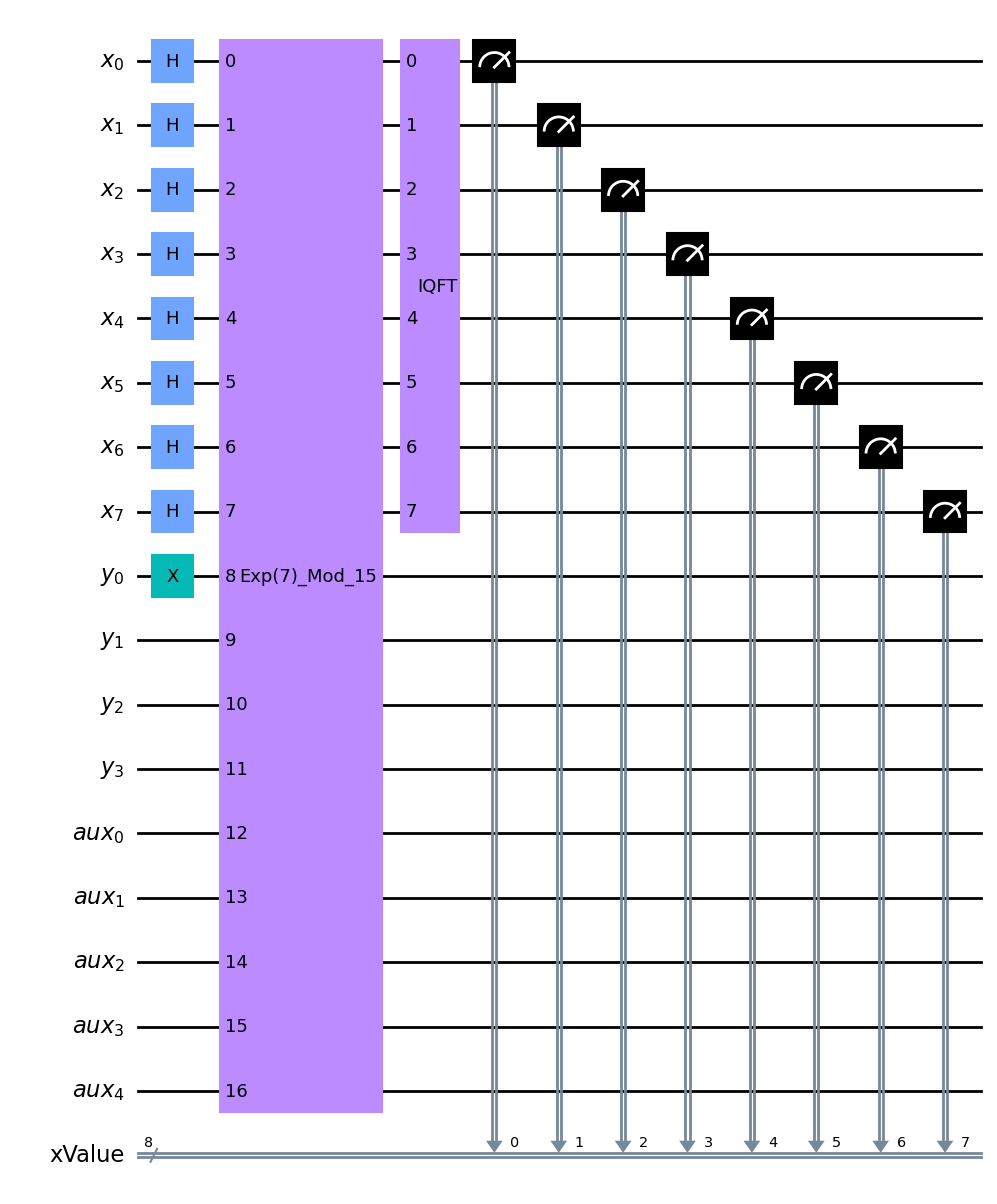

In [28]:
circuit = shor.construct_circuit(a, N, semi_classical=False, measurement=True)
circuit.draw(output='mpl', fold=-1)

Invoke `get_order()` to run algorithm and post-process measurements. 
Setting `semi_classical` argument to `True` will run algorithm on optimized version of circuit.

In [29]:
result = shor.get_order(a, N, semi_classical=True)

implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.
implementations.shor: Measurement = 192.
implementations.shor: Measured phase = 0.75.
implementations.shor: Fractional approximation: 3/4.
implementations.shor: Success, order: r = 4 from measurement 192.
implementations.shor: Measurement = 128.
implementations.shor: Measured phase = 0.5.
implementations.shor: Fractional approximation: 1/2.
implementations.shor: Denominator 2 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*2 = 4.
implementations.shor: Measurement = 64.
implementations.shor: Measured phase = 0.25.
implementations.shor: Fractional approximation: 1/4.
implementations.shor: Success, order: r = 4 from measurement 64.


Print result. Compare it with earlier observed order.

In [30]:
print(result.total_shots, result.successful_shots)
print(result.total_counts, result.successful_counts)
print(result.order)

64 43
4 3
4


## Bob's and Eva's algorithm

Use `get_order()` to perform tasks from laboratories.
For modular power and modular inverse see: https://docs.python.org/3/library/functions.html#pow

In [33]:
N = 55 
p = 5
q = 11

c = 17 # public key part
d = pow(c, -1, (p-1) * (q-1)) # private key


a = 9 # message

b = pow(a, c, N) # encrypted message
print(d, b)

33 4


In [37]:
import random

def gcd(x, y):
    while y != 0:
        (x, y) = (y, x % y)
    return x


def find_factors(n):
    while True:
        a = random.randint(2, n)
        gcd_res = gcd(a, n)
        if 1 < gcd_res < N:  # lucky
            return gcd_res, int(n / gcd_res)
        r = shor.get_order(a, n, semi_classical=True).order
        if r % 2 == 1:
            continue
        gcd_res = gcd(pow(a, r//2) + 1, n)
        if gcd_res == 1 or gcd_res == n:
            continue
        return gcd_res, int(n / gcd_res)


def bob_algo():
    p, q = find_factors(N)
    G_N = (p-1) * (q-1)
    d = pow(c, -1, G_N)
    a = pow(b, d, N)
    return a

In [38]:
find_factors(15)

implementations.shor: Measurement = 128.
implementations.shor: Measured phase = 0.5.
implementations.shor: Fractional approximation: 1/2.
implementations.shor: Denominator 2 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*2 = 4.
implementations.shor: Measurement = 192.
implementations.shor: Measured phase = 0.75.
implementations.shor: Fractional approximation: 3/4.
implementations.shor: Success, order: r = 4 from measurement 192.
implementations.shor: Measurement = 64.
implementations.shor: Measured phase = 0.25.
implementations.shor: Fractional approximation: 1/4.
implementations.shor: Success, order: r = 4 from measurement 64.
implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.


(5, 3)

In [36]:
find_factors(55)

implementations.shor: Measurement = 1229.
implementations.shor: Measured phase = 0.300048828125.
implementations.shor: Fractional approximation: 3/10.
implementations.shor: Denominator 10 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*10 = 20.
implementations.shor: Measurement = 205.
implementations.shor: Measured phase = 0.050048828125.
implementations.shor: Fractional approximation: 1/20.
implementations.shor: Success, order: r = 20 from measurement 205.
implementations.shor: Measurement = 3072.
implementations.shor: Measured phase = 0.75.
implementations.shor: Fractional approximation: 3/4.
implementations.shor: Denominator 4 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 5*4 = 20.
implementations.shor: Measurement = 2458.
implementations.shor: Measured phase = 0.60009765625.
implementations.

(5, 11)

In [39]:
bob_algo()

implementations.shor: Measurement = 1638.
implementations.shor: Measured phase = 0.39990234375.
implementations.shor: Fractional approximation: 2/5.
implementations.shor: Denominator 5 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 4*5 = 20.
implementations.shor: Measurement = 205.
implementations.shor: Measured phase = 0.050048828125.
implementations.shor: Fractional approximation: 1/20.
implementations.shor: Success, order: r = 20 from measurement 205.
implementations.shor: Measurement = 2458.
implementations.shor: Measured phase = 0.60009765625.
implementations.shor: Fractional approximation: 3/5.
implementations.shor: Denominator 5 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 4*5 = 20.
implementations.shor: Measurement = 3072.
implementations.shor: Measured phase = 0.75.
implementations.shor

9

In [40]:
def eve_algo():
    r = shor.get_order(b, N, semi_classical=True).order
    d_p =  pow(c, -1, r)
    a = pow(b, d_p, N)
    return a

In [41]:
eve_algo()

implementations.shor: Measurement = 1229.
implementations.shor: Measured phase = 0.300048828125.
implementations.shor: Fractional approximation: 3/10.
implementations.shor: Success, order: r = 10 from measurement 1229.
implementations.shor: Measurement = 819.
implementations.shor: Measured phase = 0.199951171875.
implementations.shor: Fractional approximation: 1/5.
implementations.shor: Denominator 5 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*5 = 10.
implementations.shor: Measurement = 3276.
implementations.shor: Measured phase = 0.7998046875.
implementations.shor: Fractional approximation: 4/5.
implementations.shor: Denominator 5 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*5 = 10.
implementations.shor: Measurement = 2459.
implementations.shor: Measured phase = 0.600341796875.
implement

9

In [37]:
import qiskit.tools.jupyter
%qiskit_version_table